# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [ ]:

# !pip install numpy
# !pip install Pillow
# !pip install matplotlib
# !pip install scikit-image
# !pip install scipy
# !pip install tensorflow
# !pip install scikit-learn
# !pip install xgboost
# !pip install tqdm

In [12]:
import numpy as np
from PIL import Image,ImageEnhance,ImageFilter,ImageOps
import matplotlib.pyplot as plt
from skimage.filters import unsharp_mask
from scipy.ndimage import gaussian_filter
import tensorflow as tf
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,ParameterGrid
from sklearn.base import clone
from tqdm import tqdm



## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [2]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')


### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

In [13]:
# print(X_train[0])
img_matrix = X_train[0]
img=Image.fromarray(img_matrix.astype('uint8'))
img_resized = img.resize((255, 255), resample=Image.BILINEAR)
img_resized.show()

In [14]:
print(len(X_train))
print(len(X_test))

32000
8000


In [15]:
imgArray=[]
for i in range(9):
    imgArray.append([])



for i in range(1000):
    if len(imgArray[y_train[i]])>=10:continue
    imgArray[y_train[i]].append(X_train[i])
    
    
strips = [np.concatenate(imgArray[i], axis=1) for i in range(9)]
mosaic = np.vstack(strips)




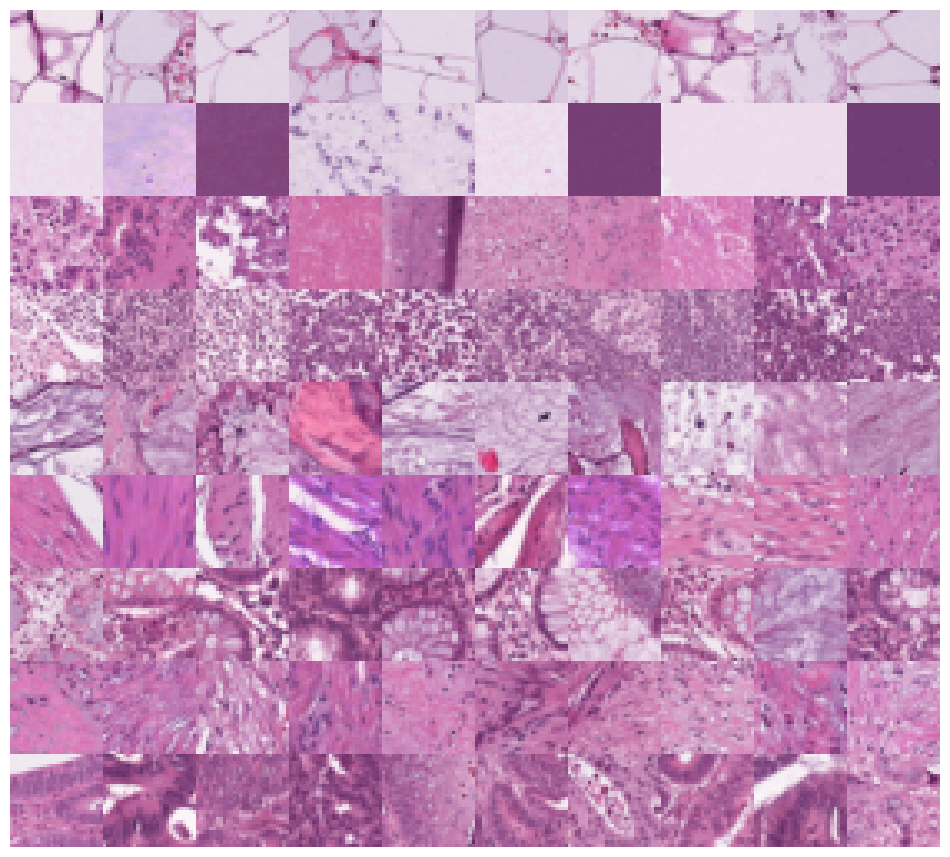

In [16]:
# the original sample
plt.figure(figsize=(12, 12))
plt.imshow(mosaic.astype('uint8'))
plt.axis('off')
plt.show()

In [17]:
#display
def displayImage(X,Y):
    imgArray=[]
    for i in range(9):
        imgArray.append([])



    for i in range(1000):
        if len(imgArray[Y[i]])>=10:continue
        imgArray[Y[i]].append(X[i])
        
        
    strips = [np.concatenate(imgArray[i], axis=1) for i in range(9)]
    mosaic = np.vstack(strips)

    plt.figure(figsize=(10, 10))
    plt.imshow(mosaic)
    plt.axis('off')
    plt.show()

In [18]:
def batch_contrast_unsharp(X, contrast_factor=2.0, unsharp_radius=1.0, unsharp_amount=1.5):

    alpha = contrast_factor
    mean = 127.5  
    Xf = X.astype(np.float32)
    Xc = (Xf - mean) * alpha + mean
    Xc = np.clip(Xc, 0, 255)

  
    blurred = gaussian_filter(Xc, sigma=(0, unsharp_radius, unsharp_radius, 0))
    detail = Xc - blurred
    Xs = Xc + unsharp_amount * detail
    Xs = np.clip(Xs, 0, 255).astype('uint8')
    return Xs

In [20]:

def autocontrast_equalize(img_array: np.ndarray, cutoff: int = 1) -> np.ndarray:
 
    
    img = Image.fromarray(img_array)
    img = ImageOps.autocontrast(img, cutoff=cutoff)
    img = ImageOps.equalize(img)
    return np.array(img, dtype=np.uint8)

def batch_autocontrast_equalize(X: np.ndarray, cutoff: int = 1) -> np.ndarray:
    return np.stack([autocontrast_equalize(img, cutoff) for img in X], axis=0)


In [21]:

def denoise_median_mode(img_array: np.ndarray, median_size: int = 3, mode_size: int = 3) -> np.ndarray:
    img = Image.fromarray(img_array)
    img = img.filter(ImageFilter.MedianFilter(size=median_size))
    img = img.filter(ImageFilter.ModeFilter(size=mode_size))
    return np.array(img, dtype=np.uint8)

def batch_denoise_median_mode(X: np.ndarray, median_size: int = 3, mode_size: int = 3) -> np.ndarray:

    return np.stack([denoise_median_mode(img, median_size, mode_size) for img in X], axis=0)



In [22]:
#Preprocess result

#1.Contrast
alpha=2.0
mean=127.5

X=X_train.astype(np.float32)
X_train_contrast=(X-mean)*alpha+mean
X_train_contrast=np.clip(X_train_contrast,0,255).astype(np.uint8)

X=X_test.astype(np.float32)
X_test_contrast=(X-mean)*alpha+mean
X_test_contrast=np.clip(X_test_contrast,0,255).astype(np.uint8)

#2.sharp&contrast
X_train_sharp=batch_contrast_unsharp(X_train)
X_test_sharp=batch_contrast_unsharp(X_test)

#3.autocontrast & equalize
X_train_auto=batch_autocontrast_equalize(X_train)
X_test_auto=batch_autocontrast_equalize(X_test)

#4. median & mode denoise
X_train_denoise=batch_denoise_median_mode(X_train)
X_test_denoise=batch_denoise_median_mode(X_test)
 



In [ ]:
displayImage(X_train,y_train)
displayImage(X_train_contrast,y_train)
displayImage(X_train_sharp,y_train)
displayImage(X_train_auto,y_train)
displayImage(X_train_denoise,y_train)


## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

在前六周的学习中，我们所学习的算法包括，Logistic Regression，Naïve Bayes，Ada Boost， Gradient Boosting，KNN，SVM以及Random Forest。
对于一个基于图片的分类任务时，我认为最好的选择是Gradient Boosting
Gradient Boosting（如 XGBoost / LightGBM）可以在中等规模的图像特征数据上实现最优的分类效果，具有强大的非线性建模能力、良好的泛化能力，并能有效处理高维度特征，这正好契合 PathMNIST 子集的特征结构（高维、小图像、多类别）。
对于Logistic Regression，图片分类问题很难线性化处理。
对于Naïve Bayes，前提的假设就不成立
对于Decision Tree，单棵树容易过拟合，泛化能力差
对于Bagging，虽能缓解过拟合但基模型（如树）弱，效果不如 GBDT 精细
对于AdaBoost，其对噪声敏感，图像数据中可能存在模糊类边界
对于KNN，高维空间中距离计算不可靠，预测阶段慢，难扩展
对于SVM，性能好但对大数据训练慢，尤其是输入维度很高时
对于Random Forest， 表现稳定但粗粒度建模，效果通常略逊于 GBDT

In [24]:

def find_best_gb_params(X_train, y_train, description=""):

    # 展平归一化
    X_train_flat = X_train.reshape((X_train.shape[0], -1)) / 255.0

    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5]
    }

    model = GradientBoostingClassifier(random_state=0)

    best_score = 0
    best_params = None

    print(f"{description} - Start GB GridSearch, total {len(ParameterGrid(param_grid))} ...")
    for params in tqdm(ParameterGrid(param_grid)):
        clf = clone(model).set_params(**params)
        scores = cross_val_score(clf, X_train_flat, y_train, cv=2, scoring='accuracy')
        avg_score = scores.mean()
        if avg_score > best_score:
            best_score = avg_score
            best_params = params

    print(f"{description} - Best param: {best_params}")
    print(f"{description} - Best score: {best_score:.4f}")
    return best_params
    
def find_best_xgb_params(X_train, y_train, description=""):
    from sklearn.model_selection import cross_val_score
    from sklearn.base import clone

    X_train_flat = X_train.reshape((X_train.shape[0], -1)) / 255.0

    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5]
    }

    base_model = xgb.XGBClassifier(
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=0
    )

    best_score = 0
    best_params = None

    print(f"{description} - Start GB GridSearch, total{len(ParameterGrid(param_grid))} ...")
    for params in tqdm(ParameterGrid(param_grid)):
        clf = clone(base_model).set_params(**params)
        scores = cross_val_score(clf, X_train_flat, y_train, cv=2, scoring='accuracy')
        avg_score = scores.mean()
        if avg_score > best_score:
            best_score = avg_score
            best_params = params

    print(f"{description} - Best param: {best_params}")
    print(f"{description} - Best score: {best_score:.4f}")
    return best_params
    
def train_and_evaluate_gb(X_train, y_train, X_test, y_test, description=""):
    # 1. 数据展平和归一化
    X_train_flat = X_train.reshape((X_train.shape[0], -1)) / 255.0
    X_test_flat = X_test.reshape((X_test.shape[0], -1)) / 255.0

    # 2. Gradient Boosting 模型
    gb_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.5, random_state=0)
    
    # 交叉验证
    cvKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    cv_scores = cross_val_score(gb_model, X_train_flat, y_train, cv=cvKFold, scoring='accuracy')
    print(f"{description} - GB Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # 训练 Gradient Boosting
    gb_model.fit(X_train_flat, y_train)

    # 测试集评估
    y_pred_gb = gb_model.predict(X_test_flat)
    gb_acc = accuracy_score(y_test, y_pred_gb)
    print(f"{description} - GB Test Accuracy: {gb_acc:.4f}")
    print(f"{description} - GB Classification Report:")
    print(classification_report(y_test, y_pred_gb))
    
def train_and_evaluate_xgb(X_train, y_train, X_test, y_test, description=""):
    # 1. 数据展平和归一化
    X_train_flat = X_train.reshape((X_train.shape[0], -1)) / 255.0
    X_test_flat = X_test.reshape((X_test.shape[0], -1)) / 255.0

    # 2. XGBoost 模型（使用 GPU）
    xgb_model = xgb.XGBClassifier(
        tree_method='gpu_hist',       
        predictor='gpu_predictor',    
        n_estimators=50,              
        learning_rate=0.5,            
        max_depth=6,                  
        use_label_encoder=False,      
        eval_metric='mlogloss',       
        random_state=0
    )

    # 3. 交叉验证
    cvKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    xgb_scores = cross_val_score(xgb_model, X_train_flat, y_train, cv=cvKFold, scoring='accuracy')
    print(f"{description} - XGBoost Cross-validation accuracy: {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")

    # 4. 训练 XGBoost
    xgb_model.fit(X_train_flat, y_train)

    # 5. 测试集评估
    y_pred_xgb = xgb_model.predict(X_test_flat)
    xgb_acc = accuracy_score(y_test, y_pred_xgb)
    print(f"{description} - XGBoost Test Accuracy: {xgb_acc:.4f}")
    print(f"{description} - XGBoost Classification Report:")
    print(classification_report(y_test, y_pred_xgb))
    




In [26]:
# Hyperparm
print(X_train[:500].shape)
# print(find_best_gb_params(X_train_denoise,y_train,"Orignal_test"))
# print(find_best_xgb_params(X_train_denoise,y_train,"Orignal_test"))

(500, 28, 28, 3)


### Fully connected neural network

In [ ]:
print(X_train)

In [ ]:
import os, random
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # 强制只用 CPU（上面已设置 TF_DETERMINISTIC_OPS=1）
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

init = keras.initializers.GlorotUniform
zeros = keras.initializers.Zeros()

data_augment = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", seed=42),
  tf.keras.layers.RandomRotation(0.1, seed=42),
  tf.keras.layers.RandomZoom(0.1, seed=42),
])

model = keras.models.Sequential([
    data_augment,
    keras.layers.Flatten(input_shape=(28,28,3)),
    keras.layers.Dense(500, activation='relu',
                       kernel_initializer=init(seed=42),
                       bias_initializer=zeros),
    keras.layers.Dropout(0.3, seed=42),
   
    keras.layers.Dense(100, activation='relu',
                       kernel_initializer=init(seed=43),
                       bias_initializer=zeros),
    keras.layers.Dropout(0.2, seed=43),
    keras.layers.Dense(9, activation='softmax',
                       kernel_initializer=init(seed=45),
                       bias_initializer=zeros),
])


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
# model.summary()

In [ ]:


# 1. 归一化到 [0,1]
X_train_float = X_train.astype("float32") / 255.0
X_test_float  = X_test.astype("float32")  / 255.0

# 2. 训练（fit）
history = model.fit(
    X_train_float, y_train,
    shuffle=False,
    validation_split=0.1,  
    epochs=20,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss",
                                      patience=5,
                                      restore_best_weights=True)
    ]
)

# 3. 查看训练曲线（可选）
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.show()

# 4. 在测试集上评估
test_loss, test_acc = model.evaluate(X_test_float, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# 5. 预测新的样本
probs = model.predict(X_test_float[:10])       # 返回 shape=(10,9) 的概率分布
preds = probs.argmax(axis=1)             # 取最大概率对应的类别
print("Predicted:", preds, "True:", y_test[:10])


In [ ]:
X_train_float = X_train.astype("float32") / 255.0
X_test_float  = X_test.astype("float32")  / 255.0
result=[]
for  i in range(10):
    for  j in range(10):
        #model define
        model = keras.models.Sequential([
            data_augment,
            keras.layers.Flatten(input_shape=(28,28,3)),
            keras.layers.Dense((i+1)*100, activation='relu',
                            kernel_initializer=init(seed=42),
                            bias_initializer=zeros),
            keras.layers.Dropout(0.3, seed=42),
        
            keras.layers.Dense((j+1)*100, activation='relu',
                            kernel_initializer=init(seed=43),
                            bias_initializer=zeros),
            keras.layers.Dropout(0.2, seed=43),
            keras.layers.Dense(9, activation='softmax',
                            kernel_initializer=init(seed=45),
                            bias_initializer=zeros),
        ])
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        
        history = model.fit(
            X_train_float, y_train,
            shuffle=False,
            validation_split=0.1,  
            epochs=20,
            batch_size=64,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor="val_loss",
                                            patience=5,
                                            restore_best_weights=True)
            ]
        )
        test_loss, test_acc = model.evaluate(X_test_float, y_test, verbose=0)
        print(f"{(i+1)*100} {(j+1)*100} Test accuracy: {test_acc:.4f}")
        result.append(f"{(i+1)*100} {(j+1)*100} Test accuracy: {test_acc:.4f}")
    

In [ ]:
objectResult=[]
for s in result:
    split=s.split(" ")

    objectResult.append({"firstLayer":split[0],"secondLayer":split[1],"accuracy":split[-1]})
for r in objectResult:
    print(r)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 原始数据
data = objectResult

# 转换为 DataFrame 并类型转换
df = pd.DataFrame(data)
df['firstLayer'] = df['firstLayer'].astype(int)
df['secondLayer'] = df['secondLayer'].astype(int)
df['accuracy'] = df['accuracy'].astype(float)

# 生成 3D 三角面片曲面图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(
    df['firstLayer'],
    df['secondLayer'],
    df['accuracy'],
    linewidth=0.2
)

# 设置坐标轴标签
ax.set_xlabel('First Layer Units')
ax.set_ylabel('Second Layer Units')
ax.set_zlabel('Accuracy')

plt.show()

In [ ]:
sorted_by_accuracy=sorted(objectResult,key=lambda x:x['accuracy'],reverse=True)
print(sorted_by_accuracy[:10])

In [ ]:


# 1. 归一化到 [0,1]
X_train_denoise_float = X_train_denoise.astype("float32") / 255.0
X_test_denoise_float  = X_test_denoise.astype("float32")  / 255.0

# 2. 训练（fit）
history = model.fit(
    X_train_denoise_float, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss",
                                      patience=5,
                                      restore_best_weights=True)
    ]
)

# 3. 查看训练曲线（可选）
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.show()

# 4. 在测试集上评估
test_loss, test_acc = model.evaluate(X_test_denoise_float, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# 5. 预测新的样本
probs = model.predict(X_test_denoise_float[:10])       # 返回 shape=(10,9) 的概率分布
preds = probs.argmax(axis=1)             # 取最大概率对应的类别
print("Predicted:", preds, "True:", y_test[:10])


In [ ]:


# 1. 归一化到 [0,1]
X_train_auto_float = X_train_auto.astype("float32") / 255.0
X_test_auto_float  = X_test_auto.astype("float32")  / 255.0

# 2. 训练（fit）
history = model.fit(
    X_train_auto_float, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss",
                                      patience=5,
                                      restore_best_weights=True)
    ]
)

# 3. 查看训练曲线（可选）
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.show()

# 4. 在测试集上评估
test_loss, test_acc = model.evaluate(X_test_auto_float, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# 5. 预测新的样本
probs = model.predict(X_test_auto_float[:10])       # 返回 shape=(10,9) 的概率分布
preds = probs.argmax(axis=1)             # 取最大概率对应的类别
print("Predicted:", preds, "True:", y_test[:10])


### Convolutional neural network

In [ ]:
def train_and_evaluate_cnn(X_train, y_train, X_test, y_test, description=""):
    num_classes = len(np.unique(y_train))
    
    # 1. 归一化
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # 2. One-hot 编码
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    # 3. 模型定义
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # 4. 模型训练
    model.fit(X_train, y_train_cat, epochs=10, batch_size=128, validation_split=0.1, verbose=0)

    # 5. 测试评估
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, y_pred_labels)
    print(f"{description} - Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred_labels))
    
train_and_evaluate_cnn(X_train, y_train, X_test, y_test, "original")
train_and_evaluate_cnn(X_train_contrast, y_train, X_test_contrast, y_test, "contrast")
train_and_evaluate_cnn(X_train_sharp, y_train, X_test_sharp, y_test, "sharp")
train_and_evaluate_cnn(X_train_auto, y_train, X_test_auto, y_test, "auto")
train_and_evaluate_cnn(X_train_denoise, y_train, X_test_denoise, y_test, "denoise")

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def preprocess_dataset(X: np.ndarray) -> np.ndarray:

    N = X.shape[0]
    # 1. 扁平化
    X_flat = X.reshape(N, -1)           # 正确的 reshape 调用
    # 2. 标准化（零均值单位方差）
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
    return X_scaled




In [ ]:
X_train_original_pre=preprocess_dataset(X_train)
X_test_original_pre=preprocess_dataset(X_test)

X_train_contrast_pre=preprocess_dataset(X_train_contrast)
X_test_contrast_pre=preprocess_dataset(X_test_contrast)

X_train_sharp_pre=preprocess_dataset(X_train_sharp)
X_test_sharp_pre=preprocess_dataset(X_test_sharp)

X_train_auto_pre=preprocess_dataset(X_train_auto)
X_test_auto_pre=preprocess_dataset(X_test_auto)

X_train_denoise_pre=preprocess_dataset(X_train_denoise)
X_test_denoise_pre=preprocess_dataset(X_test_denoise)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split



# 定义 MLP
clf = MLPClassifier(
    hidden_layer_sizes=(128, 128,128),  # 两层：128 + 64 个神经元
    activation='relu',             # 激活函数
    solver='adam',                 # 优化器
    alpha=1e-4,                    # L2 正则化系数
    learning_rate_init=1e-3,       # 初始学习率
    max_iter=200,                  # 最大迭代次数（Epoch）
    random_state=42,
    early_stopping=True,           # 如果验证集不再提升则提前停止
    validation_fraction=0.1        # 用 10% 验证集做 early stopping
)



In [ ]:
# 训练
clf.fit(X_train_original_pre, y_train)  
# 评估
print("Train accuracy:", clf.score(X_train_original_pre, y_train))
print("Val   accuracy:", clf.score(X_test_original_pre, y_test))

In [ ]:
# 训练
clf.fit(X_train_contrast_pre, y_train)  
# 评估
print("Train accuracy:", clf.score(X_train_contrast_pre, y_train))
print("Val   accuracy:", clf.score(X_test_contrast_pre, y_test))

In [ ]:
# 训练
clf.fit(X_train_sharp_pre, y_train)  
# 评估
print("Train accuracy:", clf.score(X_train_sharp_pre, y_train))
print("Val   accuracy:", clf.score(X_test_sharp_pre, y_test))

In [ ]:
# 训练
clf.fit(X_train_denoise_pre, y_train)  
# 评估
print("Train accuracy:", clf.score(X_train_denoise_pre, y_train))
print("Val   accuracy:", clf.score(X_test_denoise_pre, y_test))

In [ ]:
# 训练
clf.fit(X_train_auto_pre, y_train)  
# 评估
print("Train accuracy:", clf.score(X_train_auto_pre, y_train))
print("Val   accuracy:", clf.score(X_test_auto_pre, y_test))

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network